# Predicting Knowledge Levels

#missing summary

### Introduction

A published paper on the development of intuitive knowledge classifiers collected data on undergraduate students in the Faculty of Technology in the Department of Computer Engineering at Gazi University in October of 2009. It measured their knowledge on the subject of Electrical DC Machines using study time, study repetition and exam performance to determine their knowledge level. The data they released contains 6 total variables: the degree of study time for goal object materials, the degree of repetition number of user for goal object materials, the degree of study time of user for related object with goal object, the exam performance of user for related objects with goal object, the exam performance of user for goal objects, and finally the knowledge of the user. To simplify this data set for us to determine the knowledge level of the user, we decided to only use STG (the degree of study time for goal object materials), PEG (the exam performance of the user for goal objects), and UNS (the knowledge level of the user). In other words, from this data we can use study time, and exam performance to predict our own user’s knowledge level and test which is a better determining factor to knowledge level, study time or exam performance. We decided to use these two variables to determine user knowledge because we were curious on what mattered most for students’ knowledge level, study time or how they performed on the exam. <br/>

Question: If a user spends a minimal time studying (< 0.2 STG) but obtains a high exam performance (> 0.9 PEG), does the user have a high knowledge level?<br/>

The dataset being used is User Knowledge Modeling Data Set and includes factors that measured the study time of more and less specific information for an exam as well as study repetition of this material. Exam performance on specific and less specific information was also measured. These factors were recorded on a scale of 0.00-1.00. These observations were then used to determine the target value of the knowledge level which was categorized with very low, low, middle and high. 


### Methods and Results

#### Preliminary exploratory data analysis:

To answer our predictive question, we began by loading the required packages, including tidyverse, readxl (as our raw data was found on an excel sheet), repr, and tidymodels.

In [11]:
install.packages("rlang")
install.packages("tidymodels")
install.packages("kknn")



The downloaded binary packages are in
	/var/folders/tx/7d0rdqt930q3m1lsb2vvbfj40000gn/T//RtmpRVsjVh/downloaded_packages

The downloaded binary packages are in
	/var/folders/tx/7d0rdqt930q3m1lsb2vvbfj40000gn/T//RtmpRVsjVh/downloaded_packages


also installing the dependency ‘igraph’





The downloaded binary packages are in
	/var/folders/tx/7d0rdqt930q3m1lsb2vvbfj40000gn/T//RtmpRVsjVh/downloaded_packages


In [13]:
library(kknn)
library(tidyverse)
library(readxl)
library(repr)
library(tidymodels)

We then loaded the data set into the Juypter file. Because the data set was an excel file and came from the web, we had to use the ```download.file``` function to download and convert the data from its original format to something we could work with and analyze. The excel also contained several sheets and was already split up into training and test data, which we used to create our training and test variables. The word format was inconsistent between sheets; the training data's user knowledge level was typed in lowercase and with underscores, and the test data's user knowledge level was typed in regular case and with spaces. So to ensure consistency between data, we converted the "Very Low" value into "very_low." The data was already standarized and so this step was not required here.

In [ ]:

#fix loading data/ either change it to read_xls or dowload it to the correct folder

url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/00257/Data_User_Modeling_Dataset_Hamdi%20Tolga%20KAHRAMAN.xls"
data <- "data.xls"
download.file(url, data)
knowledge_train_data <- read_excel(data,2)
knowledge_test_data <- read_excel(data,3)
knowledge_test_data[knowledge_test_data == "Very Low"] <- "very_low"

New names:
• `` -> `...7`
• `` -> `...8`
New names:
• `` -> `...7`
• `` -> `...8`


With our data now loaded in, we could select the specific columns (which include our predictors and classifier variables) from the data set. These columns include the User Knowledge Level (UNS, the classification variable), Study Time for Goal Object Materials (STG, a predictor), and Exam Performance for Goal Object (PEG, another predictor). Because the UNS column contains the classification groups, we mutated this from a string to factor data type. We loaded the first couple of rows from each table to observe these changes. (See Table 1 and Table 2 below)

In [5]:
knowledge_train_data <- knowledge_train_data %>%
    mutate(UNS = as_factor(UNS)) %>%
    select(STG,PEG,UNS)

knowledge_test_data <- knowledge_test_data %>%
   mutate(UNS = as_factor(UNS)) %>%
    select(STG,PEG,UNS)

head(knowledge_train_data)
head(knowledge_test_data)

STG,PEG,UNS
<dbl>,<dbl>,<fct>
0.00,0.00,very_low
0.08,0.90,High
0.06,0.33,Low
0.10,0.30,Middle
0.08,0.24,Low
0.09,0.66,Middle


STG,PEG,UNS
<dbl>,<dbl>,<fct>
0.00,0.05,very_low
0.05,0.14,Low
0.08,0.85,High
0.20,0.85,High
0.22,0.90,High
0.14,0.30,Low


*Table 1: First six rows of the Training Data <br/>
Table 2: First six rows of the Testing Data*

Next, we wanted to see the distribution of knowledge levels within the training and testing data, so we grouped the data by the knowledge level, found their counts, and then calculated the percent of each class. From Table 3, we can see that 9% of users have a very low knowledge level, 24% have a high knowledge level, 32% have a low knowledge level, and 34% have a middle knowledge level. Table 4 (testing data) on the other hand, shows that 18% of users have a very low knowledge level, 27% have a high knowledge level, 32% have a low knowledge level, and 23% have a middle knowledge level. We will have to keep these differences in mind during the randomization process and as we conduct further analysis.

In [6]:
num_obs <- nrow(knowledge_train_data)
know_percentage_train <- knowledge_train_data %>%
  group_by(UNS) %>%
  summarize(
    count = n(),
    percentage = n() / num_obs * 100 )
know_percentage_train

UNS,count,percentage
<fct>,<int>,<dbl>
very_low,24,9.302326
High,63,24.418605
Low,83,32.170543
Middle,88,34.108527


*Table 3: Count and Percent of User Knowledge Levels in the training data.*

In [7]:
num_obs2 <- nrow(knowledge_test_data)
know_percentage_test <- knowledge_test_data %>%
  group_by(UNS) %>%
  summarize(
    count = n(),
    percentage = n() / num_obs2 * 100 )
know_percentage_test

UNS,count,percentage
<fct>,<int>,<dbl>
very_low,26,17.93103
Low,46,31.72414
High,39,26.89655
Middle,34,23.44828


*Table 4: Count and Percent of User Knowledge Levels in the testing data.*

We still wanted to understand our data a bit more. To do so, we wrangled the training data a bit more to generate a table of the mean STG and PEG and the minimum and maximum values of the predictors for each knowledge level. This helped us get a sense of the boundaries for each class and the variance within each predictor (See Table 5 below).

In [8]:
knowledge_train_summary <- knowledge_train_data %>%
    group_by(UNS) %>%
    summarize(count = n(), 
              mean_STG = mean(STG), 
              mean_PEG = mean(PEG),
             max_STG = max(STG), 
              max_PEG = max(PEG),
             min_STG = min(STG), 
              min_PEG = min(PEG))
knowledge_train_summary

UNS,count,mean_STG,mean_PEG,max_STG,max_PEG,min_STG,min_PEG
<fct>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
very_low,24,0.3057917,0.09083333,0.68,0.24,0.00,0.00
High,63,0.4216508,0.77253968,0.99,0.93,0.00,0.47
Low,83,0.3211446,0.23762651,0.73,0.35,0.02,0.01
Middle,88,0.3999773,0.54238636,0.80,0.83,0.06,0.25


*Table 5: Means, Minimums, and Maximums of Selected Variables in Training Data*

All these tables helped us understand the data but still required attentive interpretation. So we now created a visualization of the User Knowledge Level distribution based on the Exam Performance and Study Time variables. The plot below shows how the knowledge levels are stacked vertically like layers, where study time can vary from 0 to 1 for each class, but the exam performance imposes somewhat of a boundary on each category (See Figure 1 below).

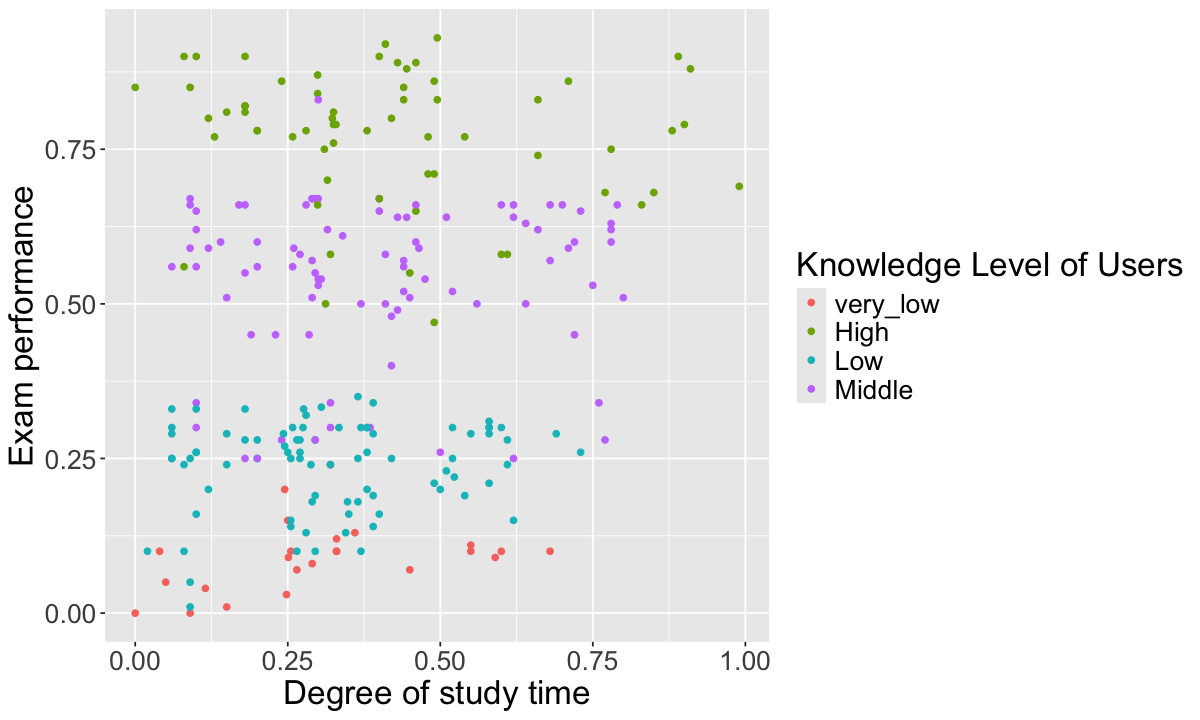

In [9]:
options(repr.plot.width=10, repr.plot.height=6)
knowledge_train_plot <- knowledge_train_data %>%
    ggplot(aes(x=STG, y= PEG, colour = UNS)) +
        labs(x = "Degree of study time",
             y = "Exam performance",
            colour = 'Knowledge Level of Users') +
        geom_point() +
        theme(text = element_text(size = 20))
knowledge_train_plot

*Figure 1: Visualization of the distribution of Knowledge Levels based on Exam Performance and Study Time*

#### Main Analysis and Results

This wraps up our preliminary wrangling and analysis of the data. With this exploratory summarization, we were now ready to move on to the main data analysis and ultimately answer the predictive question we formulated prior. As this was a classification problem, we had to start by setting a seed to make our work reproducible. After that was done, we moved on to tuning our classifier. This required us to make a recipe based on our training data and cross-validating the different K values to find the most accurate one to use in our classification analysis. We used five folds in the cross-validation step and tested k-nearest-neighbor values from 1 to 15. We then isolated the accuracy values and produced a plot of these accuracies again their specified K value. From Figure 2 below, we can see K values from 5 to 8 are consistently accurate. Still, the most precise result occurred when 12 neighbors were used, which is the value we decided to use for further classifications.

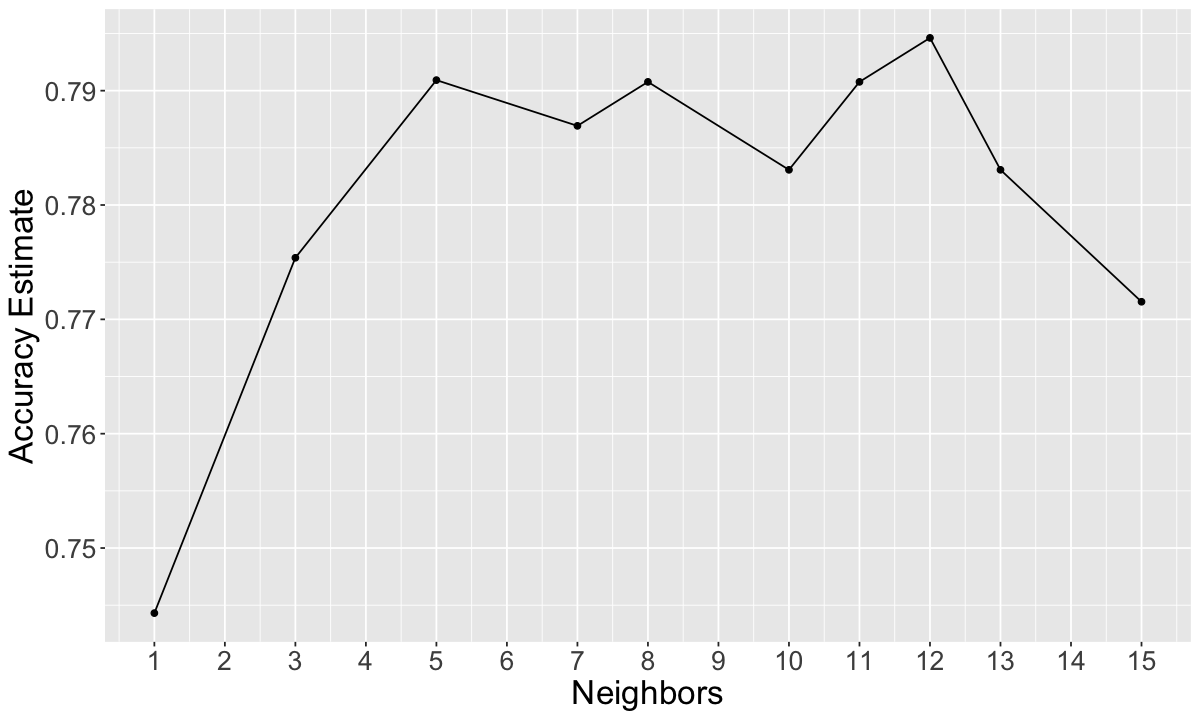

In [14]:
set.seed(1234) 

options(repr.plot.height = 6, repr.plot.width = 10)

know_recipe <- recipe(UNS ~ ., data = knowledge_train_data)

knn_tune <- nearest_neighbor(weight_func = "rectangular", 
                             neighbors = tune()) %>%
                            set_engine("kknn") %>%
                            set_mode("classification")

know_vfold <- vfold_cv(knowledge_train_data, v = 5, strata = UNS)

k_vals <- tibble(neighbors = seq(from = 1, to = 15, by = 1))

know_results <- workflow() %>%
    add_recipe(know_recipe) %>%
    add_model(knn_tune) %>%
    tune_grid(resamples = know_vfold, grid = 10) %>%
    collect_metrics()

accuracies <- know_results %>% 
    filter(.metric == "accuracy")

cross_val_plot <- ggplot(accuracies, aes(x = neighbors, y = mean))+
    geom_point() +
    geom_line() +
    labs(x = "Neighbors", y = "Accuracy Estimate") +
    scale_x_continuous(breaks = seq(0, 15, by = 1)) +
    theme(text = element_text(size = 20))
cross_val_plot

*Figure 2: Classification accuracies for each number of neighbors*

Using the test data and k = 12 neighbors, we trained the classifier and measured the accuracy of the classification results. Table  6 below shows a 79% accuracy, and Matrix 1 shows where the classifier was wrong. We can see that 26 times an observation was predicted as Low when it was not actually in the Low category. An accuracy of 79% is not terrible but also not ideal. However, this is as accurate as possible with the neighbor value and the given data. 

In [15]:
know_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 12) %>%
  set_engine("kknn") %>%
  set_mode("classification")

know_fit <- know_spec %>% 
       fit(UNS ~ ., data = knowledge_train_data)

know_predictions <- predict(know_fit , knowledge_test_data) %>%
      bind_cols(knowledge_test_data)

#reorder the levels of UNS 
know_predictions$UNS <- factor(know_predictions$UNS, levels=c("very_low", "High", "Low", "Middle"))

know_metrics <- know_predictions %>%
        metrics(truth = UNS, estimate = .pred_class)  
know_metrics

know_conf_mat <- know_predictions %>% 
      conf_mat(truth = UNS, estimate = .pred_class)

know_conf_mat

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.7862069
kap,multiclass,0.7032612


          Truth
Prediction very_low High Low Middle
  very_low       10    0   0      0
  High            0   35   0      0
  Low            16    0  45     10
  Middle          0    4   1     24

*Table 6: Classification Accuracy (k = 12) <br/>
Matrix 1: False Positives and Accurate Classifications*

We randomly created five new observations with given STG and PEG values using a new seed. We ensured that these values represented minimal studying time but a high exam performance. The goal was to now classify these observations using the classifier designed prior. Table 7 shows these specific values. Classifying these observations required us to call the ```predict``` function with the previous fit variable and the randomly generated data set. The predicted classes are shown in Table 8. As we can see, all observations were classified as High User Knowledge Levels.

In [16]:
set.seed(1922)
new_obs <- tibble(STG = runif(5,0,0.2),PEG=runif(5,0.85,1))
new_obs

prediction_new <- predict(know_fit, new_obs)
prediction_new

STG,PEG
<dbl>,<dbl>
0.04722599,0.8715383
0.04333416,0.8869822
0.14999154,0.8854533
0.11290258,0.9779164
0.10143310,0.9372303


.pred_class
<fct>
High
High
High
High
High


*Table 7: Randomaly generated observations to answer predictive question <br />
Table 8: Classification of Observations*

Lastly, to visualize where our new observations lie in regards to the training data, we added them to the plot of Study Time vs. Exam Performance, as seen in Figure 3 below. It is clear that the nearest neighbors to the five generated points are all in the High User Knowledge Level. This completes our data analysis and answers our predictive question.

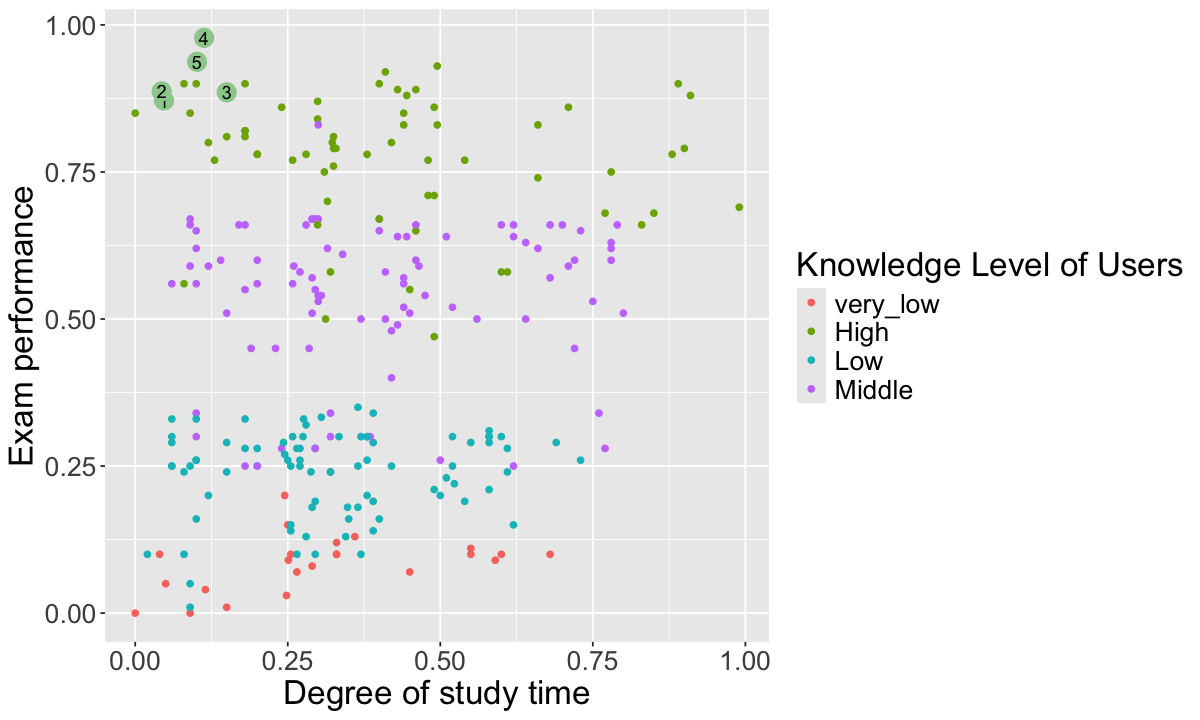

In [17]:
point1 <- c(0.04722599, 0.8715383)
point2 <- c(0.04333416, 0.8869822)
point3 <- c(0.14999154, 0.8854533)
point4 <- c(0.11290258, 0.9779164)
point5 <- c(0.10143310, 0.9372303)

options(repr.plot.width=10, repr.plot.height=6)


final_plot <- knowledge_train_data%>%
   ggplot(aes(x=STG, y= PEG, colour = UNS)) +
        labs(x = "Degree of study time",
             y = "Exam performance",
            colour = 'Knowledge Level of Users') +
        geom_point() +
     annotate("point", x=point1[1], y=point1[2], size = 5, colour = "darkseagreen3") +
     annotate("text", x=point1[1], y=point1[2], label = "1") +
     annotate("point", x=point2[1], y=point2[2], size = 5, colour = "darkseagreen3") +
     annotate("text", x=point2[1], y=point2[2], label = "2") +
     annotate("point", x=point3[1], y=point3[2], size = 5, colour = "darkseagreen3") +
     annotate("text", x=point3[1], y=point3[2], label = "3") +
     annotate("point", x=point4[1], y=point4[2], size = 5, colour = "darkseagreen3") +
     annotate("text", x=point4[1], y=point4[2], label = "4") +
     annotate("point", x=point5[1], y=point5[2], size = 5, colour = "darkseagreen3") +
     annotate("text", x=point5[1], y=point5[2], label = "5") +
        theme(text = element_text(size = 20))
final_plot

*Figure 3: Five generated points on the plot of User Knowledge Level Classification.*

### Discussion

The final plot from this analysis shows that students with a low degree of study time, but high exam performance, will be classified as “High” knowledge level. By viewing the final scatter plot, it can be seen that exam performance is generally a better predictor for knowledge level than the degree of study time, and this is especially true for points on the extremes (high or very low), and less accurate in the middle (low and middle). When random points of low study time as defined as less than 0.2 STG and high exam performance of higher than 0.9 PEG were selected, they were all classified as a high level of knowledge. This model had a prediction accuracy of 0.79, found by dividing the number or correct predictions by the number of correct predictions. A prediction accuracy of 79% is reasonable for this data set because the data set is not very large and this prediction does not have high stakes. That is to say, if this model predicts someone’s knowledge level wrong, this does not have large implications on their life, as this is just reflecting their knowledge of one specific subject, which cannot be said about all prediction models, such as tumor classification models. Another aspect that makes the stakes of this prediction lower is that the students in this are generally aware of how much they study, and their exam scores, with which they can gauge how they feel about their learning. Not every student will care how they are classified as everyone has different expectations in school and for specific courses, but knowing whether your tumor is malignant or benign has much higher stakes and needs for you to be aware of which it is and is not something that the average person can guess at. That said, this model was the most accurate when predicting high points, which is what we are studying, likely making the predictions for high levels of knowledge more accurate. <br/>

These results agree with what was expected of this study, that high exam performance and low study time will be classified as high knowledge level. This was expected because to score high on an exam, the student must have a reasonably high knowledge of the subject regardless of their study time. Since all of the points selected agreed with our hypothesis, it is true of this dataset that low study time with high exam performance is categorized as a high level of knowledge. These findings could suggest to future students of Electrical DC machines at Gazi University, that if they can score high on tests without studying much, they will be considered to have a high knowledge of the subject. This could result in confident students not studying much, as they expect their knowledge level to stay the same even if they don’t study. Though this is not problematic if they do end up scoring well on the exams, if they over-predicted their understanding of the subject and scored lower, their knowledge level will likely reflect this. This analysis could lead to questions about whether exam performance is a better indicator of knowledge level overall and about how study time affects exam performance. Both of these could give a better understanding of how knowledge of this subject is determined and the various factors that impact it. Knowing this could help students to get the most out of their studying of this subject and maximize learning and knowledge. 


### References

Kahraman, H. T., Sagiroglu, S., & Colak, I. (2012, August 21). The development of intuitive knowledge classifier and the modeling of Domain Dependent Data. Knowledge-Based Systems. Retrieved April 9, 2022, from https://www.sciencedirect.com/science/article/abs/pii/S0950705112002225?via%3Dihub <br/>

Kahraman, H. T., Sagiroglu, S., &amp; Colak, I. (2013, June 26). User knowledge modeling data set. UCI Machine Learning Repository. Retrieved April 9, 2022, from https://archive.ics.uci.edu/ml/datasets/User+Knowledge+Modeling# 

Timbers, T., Campbell, T., & Lee, M. (2022, March 2). Chapter 5 Classification I: training & predicting. Data science: A First Introduction. Retrieved April 9, 2022, from https://datasciencebook.ca/classification.html <br/>

Timbers, T., Campbell, T., & Lee, M. (2022, March 2). Chapter 6 Classification II: evaluation & tuning. Data science: A First Introduction. Retrieved April 9, 2022, from https://datasciencebook.ca/classification2.html 